# Fuzzy Inference Systems (FIS)

In [1]:
#install necessary libraries
%pip install scikit-fuzzy

In [2]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('cleaned_smart_bin_data.csv')

bin_ids = df['bin_id']  #drop bin_id column, save it for output only
X = df.drop(['priority_label', 'bin_id'], axis=1)
y = df['priority_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (81, 5)
Test shape: (36, 5)


In [4]:
#define fuzzy variables and membership functions
fill = ctrl.Antecedent(np.arange(0,101,1), 'fill')
battery = ctrl.Antecedent(np.arange(0,101,1), 'battery')
overflow = ctrl.Antecedent(np.arange(0,2,1), 'overflow')
time_since_last = ctrl.Antecedent(np.arange(0, 1.01, 0.01), 'time_since_last')
bin_status = ctrl.Antecedent(np.arange(0, 3, 1), 'bin_status')  # 0,1,2


priority = ctrl.Consequent(np.arange(0,3,1), 'priority')


# Fill level
fill['low'] = fuzz.trapmf(fill.universe, [0, 0, 20, 30])
fill['medium'] = fuzz.trimf(fill.universe, [20, 50, 70])
fill['high'] = fuzz.trimf(fill.universe, [60, 80, 90])
fill['very_high'] = fuzz.trapmf(fill.universe, [85, 95, 100, 100])

# Battery level
battery['low'] = fuzz.trapmf(battery.universe, [0, 0, 20, 30])
battery['medium'] = fuzz.trimf(battery.universe, [20, 50, 70])
battery['high'] = fuzz.trapmf(battery.universe, [60, 80, 100, 100])

# Overflow alert
overflow['false'] = fuzz.trimf(overflow.universe, [0, 0, 1])
overflow['true'] = fuzz.trimf(overflow.universe, [0, 1, 1])

# Time since last reading
time_since_last['recent'] = fuzz.trapmf(time_since_last.universe, [0, 0, 0.2, 0.3])
time_since_last['moderate'] = fuzz.trimf(time_since_last.universe, [0.3, 0.5, 0.7])
time_since_last['long'] = fuzz.trapmf(time_since_last.universe, [0.6, 0.8, 1, 1])

# Bin status
bin_status['out_of_service'] = fuzz.trimf(bin_status.universe, [0, 0, 0])
bin_status['active'] = fuzz.trimf(bin_status.universe, [1, 1, 1])
bin_status['maintenance'] = fuzz.trimf(bin_status.universe, [2, 2, 2])

# Priority output
priority['low'] = fuzz.trimf(priority.universe, [0, 0, 1])
priority['medium'] = fuzz.trimf(priority.universe, [0, 1, 2])
priority['high'] = fuzz.trimf(priority.universe, [1, 2, 2])


In [5]:
#fuzy rules
rule1 = ctrl.Rule(fill['very_high'] & overflow['true'] & bin_status['active'], priority['high'])
rule2 = ctrl.Rule(fill['high'] & battery['low'] & bin_status['active'], priority['high'])
rule3 = ctrl.Rule(fill['medium'] & time_since_last['long'] & bin_status['active'], priority['medium'])
rule4 = ctrl.Rule(fill['low'] & overflow['false'] & bin_status['active'], priority['low'])
rule5 = ctrl.Rule(bin_status['out_of_service'], priority['low'])
rule6 = ctrl.Rule(bin_status['maintenance'] & fill['high'], priority['high'])
rule7 = ctrl.Rule(bin_status['maintenance'] & fill['low'], priority['medium'])
rule8 = ctrl.Rule(fill['high'] & battery['high'] & overflow['false'], priority['high'])

priority_ctrl = ctrl.ControlSystem([
    rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8
])


In [6]:
#prediction function
def fuzzy_predict(row):
    sim = ctrl.ControlSystemSimulation(priority_ctrl)

    sim.input['fill'] = row['fill_level_percent']
    sim.input['battery'] = row['battery_level_percent']
    sim.input['overflow'] = row['overflow_alert']
    sim.input['time_since_last'] = row['time_since_last_reading_norm']
    sim.input['bin_status'] = row['bin_status_encoded']

    sim.compute()

    score = sim.output['priority']

    if score < 0.5:
        return 0, score
    elif score < 1.5:
        return 1, score
    else:
        return 2, score


In [7]:
y_train_pred = []
train_scores = []

for _, row in X_train.iterrows():
    p, s = fuzzy_predict(row)
    y_train_pred.append(p)
    train_scores.append(s)

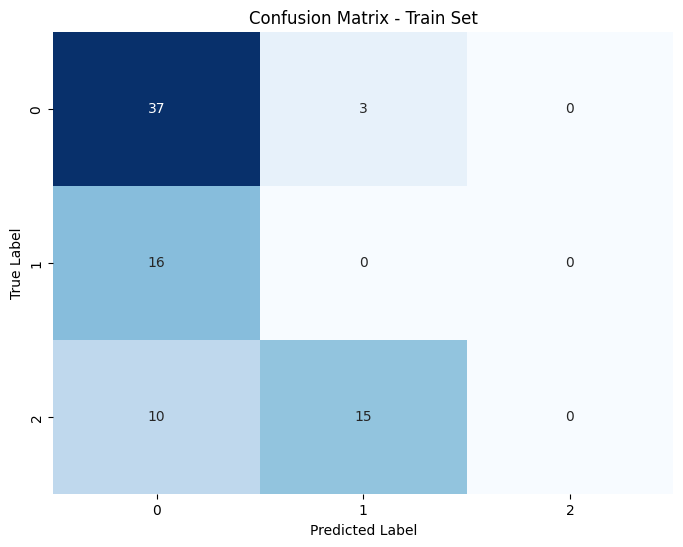

In [8]:
cm = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train Set')
plt.show()

In [9]:
#run prediction
y_pred = []
scores = []

for _, row in X_test.iterrows():
    p, s = fuzzy_predict(row)
    y_pred.append(p)
    scores.append(s)


In [10]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4722222222222222

Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.94      0.71        18
           1       0.00      0.00      0.00         7
           2       0.00      0.00      0.00        11

    accuracy                           0.47        36
   macro avg       0.19      0.31      0.24        36
weighted avg       0.28      0.47      0.35        36



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


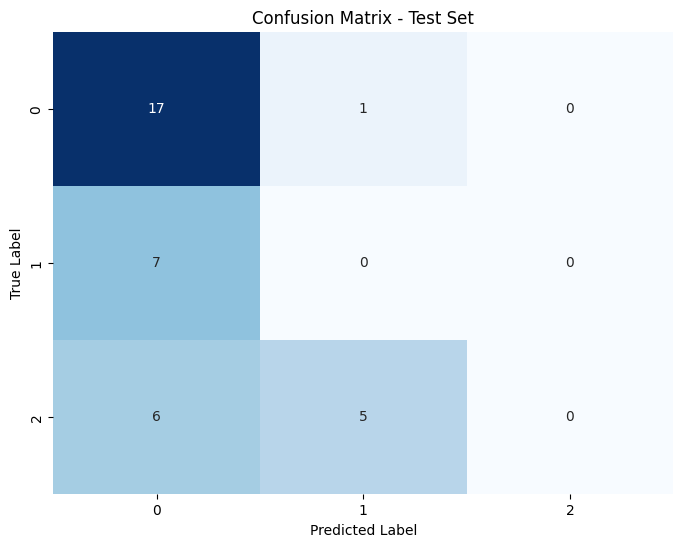

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [12]:
#print top 10 bins with the highest priority
results_fuzzy = X_test.copy()
results_fuzzy['bin_id'] = bin_ids.loc[X_test.index]
results_fuzzy['priority'] = y_pred
results_fuzzy['score'] = scores

top10_fuzzy = results_fuzzy.sort_values(
    by=['priority', 'score'],
    ascending=[False, False]
).head(10)

print(top10_fuzzy[['bin_id', 'priority', 'score']])


      bin_id  priority     score
51   BIN-103         1  1.000000
99   BIN-202         1  1.000000
74   BIN-127         1  1.000000
114  BIN-217         1  1.000000
25   BIN-026         1  1.000000
84   BIN-137         1  1.000000
110  BIN-213         0  0.333333
98   BIN-201         0  0.333333
14   BIN-015         0  0.333333
92   BIN-145         0  0.333333
